# Test linearizer

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [4]:
from linearization.analyzer import SAELinearizer

In [5]:
from linearization.loading import load_model

model = load_model()

Loaded pretrained model gelu-1l into HookedTransformer
Moving model to device:  cuda
Changing model dtype to torch.float16
Model device: cuda:0


In [6]:
model.tokenizer.decode(952)

'ull'

## GELU-1L

In [7]:
lin = SAELinearizer(num_batches=5)

Loaded pretrained model gelu-1l into HookedTransformer
Moving model to device:  cuda
Changing model dtype to torch.float16
Model device: cuda:0
Tokens shape: torch.Size([215402, 128]), dtype: torch.int64, device: cuda:0
Loading run1 from HuggingFace at 25
{'batch_size': 4096,
 'beta1': 0.9,
 'beta2': 0.99,
 'buffer_batches': 12288,
 'buffer_mult': 384,
 'buffer_size': 1572864,
 'd_mlp': 2048,
 'dict_mult': 8,
 'enc_dtype': 'fp32',
 'l1_coeff': 0.0003,
 'lr': 0.0001,
 'model_batch_size': 512,
 'num_tokens': 2000000000,
 'seed': 52,
 'seq_len': 128}
Encoder device: cuda:0


100%|██████████| 5/5 [00:00<00:00, 15.39it/s]


Num dead 0.005615234375


100%|██████████| 5/5 [00:12<00:00,  2.48s/it]


In [8]:
lin.set_feature(10996, "run1")

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 26.32it/s]


In [9]:
lin.set_example("The quick brown fox jumps over the lazy dog", 7)

torch.Size([9])
Token:  the


In [10]:
lin.set_path([("attention", 0, 3)])

Last vector length: torch.Size([512])


In [11]:
lin.model.OV[0, 1]

FactoredMatrix: Shape(torch.Size([512, 512])), Hidden Dim(64)

In [12]:
lin.feature_vectors["deembeddings"]

[tensor([-0.4922, -0.7173, -0.0663,  ...,  0.0474, -0.0120, -0.0676],
        device='cuda:0', dtype=torch.float16, grad_fn=<MvBackward0>),
 tensor([-0.1865, -0.1707,  0.0019,  ..., -0.0181,  0.0071,  0.0209],
        device='cuda:0', dtype=torch.float16, grad_fn=<MvBackward0>)]

## GELU-2L

In [13]:
lin = SAELinearizer(model_name="gelu-2l", sae_names=["l0", "l1"], layers=[0, 1], act_name="mlp_out")

Loaded pretrained model gelu-2l into HookedTransformer
Moving model to device:  cuda
Changing model dtype to torch.float16
Model device: cuda:0
Tokens shape: torch.Size([215402, 128]), dtype: torch.int64, device: cuda:0
Loading l0 from HuggingFace at gelu-2l_L0_16384_mlp_out_51
{'act_name': 'blocks.0.hook_mlp_out',
 'act_size': 512,
 'batch_size': 4096,
 'beta1': 0.9,
 'beta2': 0.99,
 'buffer_batches': 12288,
 'buffer_mult': 384,
 'buffer_size': 1572864,
 'd_mlp': 512,
 'device': 'cuda:1',
 'dict_mult': 32,
 'dict_size': 16384,
 'enc_dtype': 'fp32',
 'l1_coeff': 0.0003,
 'layer': 0,
 'lr': 0.0001,
 'model_batch_size': 512,
 'model_name': 'gelu-2l',
 'num_tokens': 2000000000,
 'remove_rare_dir': False,
 'seed': 51,
 'seq_len': 128,
 'site': 'mlp_out'}
Encoder device: cuda:0
Loading l1 from HuggingFace at gelu-2l_L1_16384_mlp_out_50
{'act_name': 'blocks.1.hook_mlp_out',
 'act_size': 512,
 'batch_size': 4096,
 'beta1': 0.9,
 'beta2': 0.99,
 'buffer_batches': 12288,
 'buffer_mult': 384,
 '

100%|██████████| 25/25 [00:01<00:00, 24.00it/s]


Num dead 0.1156005859375


100%|██████████| 25/25 [00:01<00:00, 22.70it/s]


Num dead 0.0


100%|██████████| 25/25 [01:07<00:00,  2.69s/it]


In [14]:
lin.set_feature(8, "l1")

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 27.07it/s]


In [15]:
lin.set_example("The quick brown fox jumps over the lazy dog", 7)

torch.Size([9])
Token:  the


In [16]:
lin.attributions["attn"].shape

torch.Size([2, 8, 11, 11])

## GPT2-small

In [17]:
# This takes like 30 minutes btw, but it's cool...

lin = SAELinearizer(model_name="gpt2-small", sae_names=[0, 1], layers=[0, 11], num_batches=5)

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda
Changing model dtype to torch.float16
Model device: cuda:0
Tokens shape: torch.Size([325017, 128]), dtype: torch.int64, device: cuda:0
Loading GPT2-small layer 0 from disk
Encoder device: cuda:0
Loading GPT2-small layer 1 from disk
Encoder device: cuda:0


100%|██████████| 5/5 [00:00<00:00,  8.68it/s]


Num dead 0.206573486328125


100%|██████████| 5/5 [00:00<00:00,  8.91it/s]


Num dead 0.001068115234375


100%|██████████| 5/5 [00:42<00:00,  8.50s/it]


In [18]:
lin.set_feature(8, 0, num_batches=5)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 11.12it/s]


In [19]:
lin.set_example("The quick brown fox jumps over the lazy dog. The quick brown fox jumps over the lazy dog!!!", 7)

torch.Size([20])
Token:  the


In [20]:
lin.attributions["ov"].shape

torch.Size([12, 22])

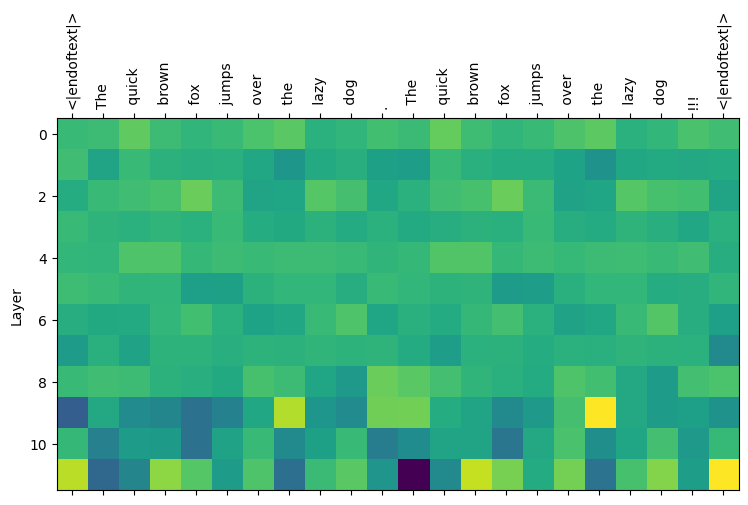

In [21]:
import matplotlib.pyplot as plt

plt.matshow(lin.attributions["ov"].detach().cpu().numpy().squeeze())
plt.xticks(range(len(lin.example)), [lin.model.tokenizer.decode(x) for x in lin.example], rotation=90)
plt.ylabel("Layer")
plt.show()